<a href="https://colab.research.google.com/github/josooik/DeepLearning/blob/main/2021_11_02_TeamProject_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from imutils import paths
import sys, os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import applications, utils, layers, models, optimizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

### 데이터

- 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os

train_dir = '/content/drive/MyDrive/딥러닝/Lecture_deeplearning_basic-main/프로젝트/dataset/train'
train_img = os.listdir(train_dir)
print(train_img)

model_dir = '/content/drive/MyDrive/딥러닝/Lecture_deeplearning_basic-main/프로젝트/dataset/model'

['normal', 'abnormal']


- 데이터 처리

In [4]:
def load_datasets(train_dir):
    print("[INFO] Load Datasets...")
    imagePaths = list(paths.list_images(train_dir))

    data = []
    labels = []
    for imagePath in imagePaths:
    	# extract the class label from the filename
    	label = imagePath.split(os.path.sep)[-2]
        #print(label)
    
    	# load the input image (224x224) and preprocess it
    	image = load_img(imagePath, target_size=(224, 224))
    	image = img_to_array(image)
    	image = applications.mobilenet_v2.preprocess_input(image)
    	# update the data and labels lists, respectively
    	data.append(image)
    	labels.append(label)
    
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = utils.to_categorical(labels)
    
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    print('* data shape:',data.shape, labels.shape)
    
    
    # the data for training and the remaining 20% for testing
    (trainX, testX, trainY, testY) = train_test_split(data, labels,
                                     test_size=0.20, stratify=labels, random_state=42)
    print('* splited data shape:',trainX.shape, testX.shape, trainY.shape, testY.shape)

    return trainX, testX, trainY, testY

In [5]:
trainX, testX, trainY, testY = load_datasets(train_dir)

[INFO] Load Datasets...
* data shape: (4600, 224, 224, 3) (4600, 2)
* splited data shape: (3680, 224, 224, 3) (920, 224, 224, 3) (3680, 2) (920, 2)


In [6]:
def train_model( trainX, testX, trainY, testY,
                 EPOCHS=1, 
                 INIT_LR=1e-4, 
                 BS=32):

    print("[INFO] Build  Model ...")
    base_model = applications.MobileNetV2( weights="imagenet", 
                                           include_top=False,
    	                                   input_tensor=layers.Input(shape=(224, 224, 3)))
    
    y = base_model.output
    y = layers.AveragePooling2D(pool_size=(7, 7))(y)
    y = layers.Flatten(name="flatten")(y)
    y = layers.Dense(128, activation="relu")(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(2, activation="softmax")(y)
    
    model = models.Model(inputs=base_model.input, outputs=y)
    model.summary()
    utils.plot_model(model, show_shapes=True)
    for layer in base_model.layers:
    	layer.trainable = False
    

    # compile our model
    print("[INFO] Compiling  Model ...")
    opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


    # construct the training image generator for data augmentation
    aug = ImageDataGenerator( rotation_range=20,
    	                      zoom_range=0.15,
    	                      width_shift_range=0.2,
    	                      height_shift_range=0.2,
    	                      shear_range=0.15,
    	                      horizontal_flip=True,
    	                      fill_mode="nearest")

    # train the head of the network
    print("[INFO] Training  Model ...")
    history = model.fit( aug.flow(trainX, trainY, batch_size=BS),
	               steps_per_epoch=len(trainX) // BS,
	               validation_data=(testX, testY),
	               validation_steps=len(testX) // BS,
	               epochs=EPOCHS)

    return history, model

In [7]:
history, model = train_model(trainX, testX, trainY, testY, EPOCHS=100)

[INFO] Build  Model ...
9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
115/115 [==============================] - 170s 1s/step - loss: 0.5601 - accuracy: 0.7764 - val_loss: 0.4672 - val_accuracy: 0.7913
Epoch 2/100
115/115 [==============================] - 165s 1s/step - loss: 0.4791 - accuracy: 0.7954 - val_loss: 0.4263 - val_accuracy: 0.7924
Epoch 3/100
115/115 [==============================] - 166s 1s/step - loss: 0.4436 - accuracy: 0.8071 - val_loss: 0.3833 - val_accuracy: 0.8217
Epoch 4/100
115/115 [==============================] - 166s 1s/step - loss: 0.4114 - accuracy: 0.8234 - val_loss: 0.3673 - val_accuracy: 0.8283
Epoch 5/100
115/115 [==============================] - 166s 1s/step - loss: 0.3996 - accuracy: 0.8315 - val_loss: 0.3413 - val_accuracy: 0.8533
Epoch 6/100
115/115 [==============================] - 164s 1s/step - loss: 0.3771 - accuracy: 0.8486 - val_loss: 0.3221 - val_accuracy: 0.8717
Epoch 7/100
115/115 [==============================] - 164s 1s/step - loss: 0.3560 - accuracy: 0.8579 - val_loss: 0.3090 - val_accuracy:

In [8]:
model.save("my_model2.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [9]:
def plot_leraning_curve(H):
    N = len(H.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N),  H.history["loss"], label="train_loss", marker='o',)
    plt.plot(np.arange(0, N),  H.history["val_loss"], label="val_loss", marker='o')
    plt.plot(np.arange(0, N),  H.history["accuracy"], label="train_acc", marker='o')
    plt.plot(np.arange(0, N),  H.history["val_accuracy"], label="val_acc", marker='o')
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("lerning_curve")
    plt.show()

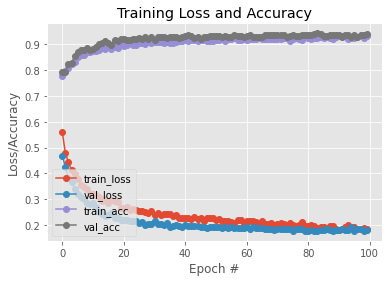

In [10]:
plot_leraning_curve((history))

In [11]:
model.evaluate(testX, testY)

29/29 [==============================] - 26s 892ms/step - loss: 0.1812 - accuracy: 0.9391


[0.18123884499073029, 0.939130425453186]